## Setup

In [48]:
# general imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from copy import deepcopy
from pprint import pprint
from time import time
import logging
from pandas_ml import ConfusionMatrix
from sklearn.metrics import confusion_matrix

# sklearn imports
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline, make_union
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, Imputer, StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *

%matplotlib inline

plt.style.use('ggplot')

## Data

In [49]:
df = pd.read_csv('https://raw.githubusercontent.com/andrewm4894/random/master/titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## X & y

In [50]:
MY_FEATURES = ['Name', 'Ticket', 'Sex', 'Fare', 'Age', 'Pclass']
MY_TARGET = 'Survived'
df['target'] = df[MY_TARGET]

X = df[MY_FEATURES]
y = df[[MY_TARGET]].rename(columns={MY_TARGET: "target"})

In [51]:
X.head()

,Name,Ticket,Sex,Fare,Age,Pclass
0,"Braund, Mr. Owen Harris",A/5 21171,male,7.2500,22.0,3
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,female,71.2833,38.0,1
2,"Heikkinen, Miss. Laina",STON/O2. 3101282,female,7.9250,26.0,3
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,female,53.1000,35.0,1
4,"Allen, Mr. William Henry",373450,male,8.0500,35.0,3


In [52]:
y.head()

,target
0,0
1,1
2,1
3,1
4,0


## EDA

### EDA: Missing Values

In [53]:
# Look for missing data in each col
print("% Missing Values")
print(X.isnull().sum()/len(X)*100)

% Missing Values
Name       0.00000
Ticket     0.00000
Sex        0.00000
Fare       0.00000
Age       19.86532
Pclass     0.00000
dtype: float64


### EDA: Summary Stats

In [54]:
# Look at X values
X.describe()

,Fare,Age,Pclass
count,891.000000,714.000000,891.000000
mean,32.204208,29.699118,2.308642
std,49.693429,14.526497,0.836071
min,0.000000,0.420000,1.000000
25%,7.910400,20.125000,2.000000
50%,14.454200,28.000000,3.000000
75%,31.000000,38.000000,3.000000
max,512.329200,80.000000,3.000000


### EDA: Value Counts

In [55]:
for x,t in zip(X.columns,X.dtypes):
    if t == 'object':        
        vc = df[x].value_counts()
        len_vc = len(vc)
        n = min(len_vc,10)
        other_sum = sum(vc[n+1:len_vc])
        other_cnt = len_vc-n
        other_cnt_pct = round(other_cnt/len_vc,2)
        print(" ")
        print("==========================")
        print(x)
        print("==========================")
        print(vc.head(n))
        print("--------------------------")
        print("{0} Other distinct values covering {1} ({2}) records.".format(other_cnt, other_sum, other_cnt_pct))
        print("==========================")

 
Name
Gheorgheff, Mr. Stanio                               1
Astor, Mrs. John Jacob (Madeleine Talmadge Force)    1
Hart, Mr. Henry                                      1
Peuchen, Major. Arthur Godfrey                       1
Walker, Mr. William Anderson                         1
Allum, Mr. Owen George                               1
Harper, Mrs. Henry Sleeper (Myna Haxtun)             1
Beavan, Mr. William Thomas                           1
Anderson, Mr. Harry                                  1
Williams, Mr. Leslie                                 1
Name: Name, dtype: int64
--------------------------
881 Other distinct values covering 880 (0.99) records.
 
Ticket
1601            7
CA. 2343        7
347082          7
3101295         6
CA 2144         6
347088          6
382652          5
S.O.C. 14879    5
4133            4
347077          4
Name: Ticket, dtype: int64
--------------------------
671 Other distinct values covering 830 (0.99) records.
 
Sex
male      577
female    314
Name

### EDA: Plots

c:\users\andrew\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
c:\users\andrew\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


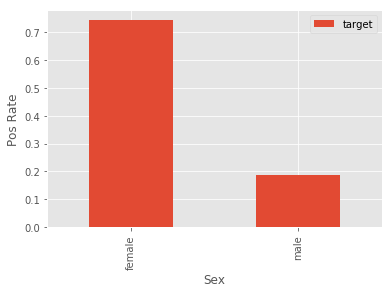

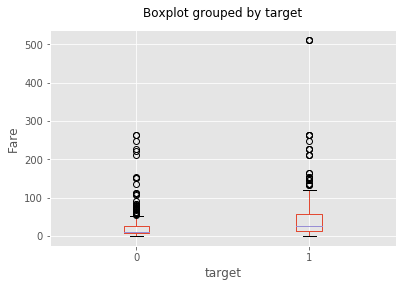

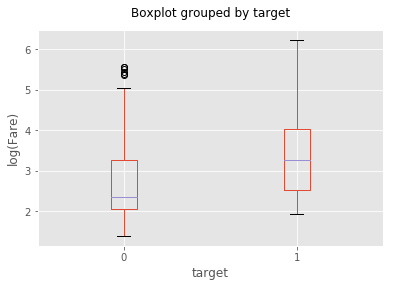

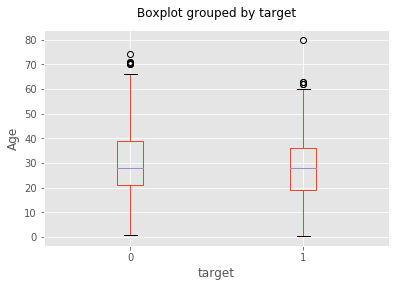

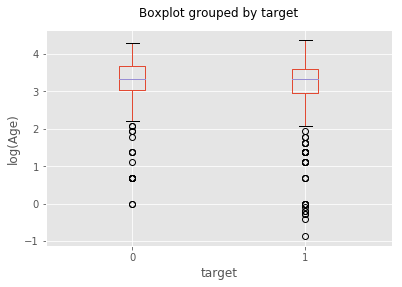

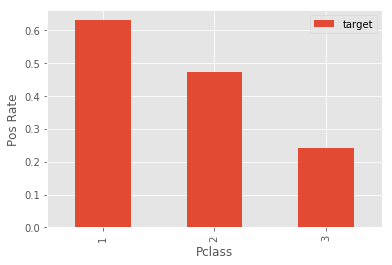

In [56]:
for x,t in zip(X.columns,X.dtypes):
    if t != 'object' and len((df[x]).unique()) > 50 :
        box = df.boxplot(column=x, by='target')
        box.set_title('')
        box.set_ylabel(x)
        box
        df_log = df[[x,'target']]
        df_log[x] = np.log(df_log[x])
        box_log = df_log.boxplot(column=x, by='target')
        box_log.set_title('')
        box_log.set_ylabel('log('+x+')')
        box_log
        del df_log
        #scatter = df.plot.scatter(x, 'target')
        #scatter.set_title('')
        #scatter.set_ylabel(x)
        #scatter
    elif len(df[x].value_counts()) <= 20:
        bar = pd.DataFrame(df.groupby([x])['target'].mean()).plot.bar()
        bar.set_ylabel('Pos Rate')
        bar.set_title('')
        bar

## Train / Dev / Test

In [57]:
dev_size = 0.2
test_size = 0.1
MY_SEED = 1 #random.seed()

X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=(dev_size + test_size), random_state = MY_SEED)
X_dev, X_test, y_dev, y_test = train_test_split(X_tmp, y_tmp, test_size=(test_size / (dev_size + test_size)), random_state = MY_SEED)

print("X_train is " + str(len(X_train)) + " rows (" + str(round(len(X_train)/len(X),2)) + ")")
print("y_train is " + str(len(y_train)) + " rows (" + str(round(len(y_train)/len(y),2)) + ")")
print("X_dev is " + str(len(X_dev)) + " rows (" + str(round(len(X_dev)/len(X),2)) + ")")
print("y_dev is " + str(len(y_dev)) + " rows (" + str(round(len(y_dev)/len(y),2)) + ")")
print("X_test is " + str(len(X_test)) + " rows (" + str(round(len(X_test)/len(X),2)) + ")")
print("y_test is " + str(len(y_test)) + " rows (" + str(round(len(y_test)/len(y),2)) + ")")

X_train is 623 rows (0.7)
y_train is 623 rows (0.7)
X_dev is 178 rows (0.2)
y_dev is 178 rows (0.2)
X_test is 90 rows (0.1)
y_test is 90 rows (0.1)


## Pipeline

### Pipeline: Features

In [97]:
# features
df_mapper = DataFrameMapper([
    
    # Fare
    (['Fare'], StandardScaler()),

    # Age
    (['Age'], [
        Imputer(), 
        StandardScaler()
    ]),

    # Sex
    ('Sex', LabelBinarizer()),
    
    # Ticket
    #('Ticket', [
    #    CountVectorizer(), 
    #    TfidfTransformer()
    #]),
    
    # Name
    #('Name', [
    #    CountVectorizer(), 
    #    TfidfTransformer()
    #]),
    
])

### Pipeline: Model

In [98]:
# build full pipeline
pipeline  = Pipeline([
    
    # features
    ('df_mapper',df_mapper),
    
    # model
    ('model', RandomForestClassifier())
])

# control to print pipeline info if needed
PRINT_PIPELINE_DEF = True
if PRINT_PIPELINE_DEF:
    # print as much info about the pipeline set up as possible
    for i in range(0,len(pipeline.steps)):
        print("================================================================================")
        pprint(pipeline.steps[i][0])
        print("----------------------------------------")
        pprint(vars(pipeline.steps[i][1]))

'df_mapper'
----------------------------------------
{'built_default': None,
 'built_features': None,
 'default': False,
 'df_out': False,
 'features': [(['Fare'],
               StandardScaler(copy=True, with_mean=True, with_std=True)),
              (['Age'],
               [Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0),
                StandardScaler(copy=True, with_mean=True, with_std=True)]),
              ('Sex',
               LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False))],
 'input_df': False,
 'sparse': False,
 'transformed_names_': []}
'model'
----------------------------------------
{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
 'bootstrap': True,


## Parameters

In [99]:
# control to print params easily available for CV
PRINT_PIPELINE_PARAMS = False
if PRINT_PIPELINE_PARAMS:
    # print full list of params
    pprint(pipeline.get_params())

In [142]:
# set params
parameters = {
    #"model__max_features": [0, 3],
    "model__n_estimators": [50, 100]
}
pprint(parameters)

{'model__n_estimators': [50, 100]}


## Fit Pipeline

In [143]:
if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    model = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    model.fit(X_train, y_train['target'])
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % model.best_score_)
    print("Best parameters set:")
    best_parameters = model.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['df_mapper', 'model']
parameters:
{'model__n_estimators': [50, 100]}
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    7.0s finished


done in 8.032s

Best score: 0.782
Best parameters set:
	model__n_estimators: 50


## Predictions

In [144]:
target_counts = y_train.target.value_counts()
target_len = len(y_train.target)
target_rates = target_counts/target_len
print(target_counts)
print(target_rates)

0    396
1    227
Name: target, dtype: int64
0    0.635634
1    0.364366
Name: target, dtype: float64


### Predictions: Probabilities

(623, 2)
(178, 2)
(90, 2)


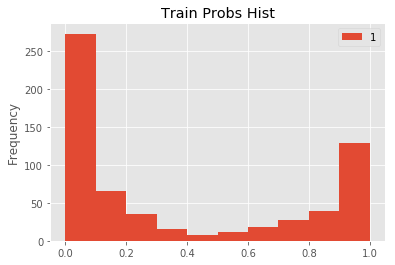

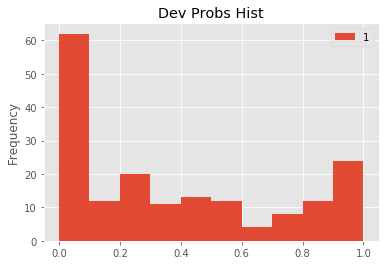

In [145]:
# get probs
y_train_pred_probs = pd.DataFrame(model.predict_proba(X_train), columns=model.best_estimator_.classes_)
y_dev_pred_probs = pd.DataFrame(model.predict_proba(X_dev), columns=model.best_estimator_.classes_)
y_test_pred_probs = pd.DataFrame(model.predict_proba(X_test), columns=model.best_estimator_.classes_)

print(y_train_pred_probs.shape)
print(y_dev_pred_probs.shape)
print(y_test_pred_probs.shape)

# plot train probs
train_probs_plot = y_train_pred_probs.plot.hist(x=0)
train_probs_plot.set_title('Train Probs Hist')
train_probs_plot

# plot dev probs
dev_probs_plot = y_dev_pred_probs.plot.hist(x=0)
dev_probs_plot.set_title('Dev Probs Hist')
dev_probs_plot

### Predictions: Classes (Model)

In [146]:
# get preds
y_train_pred = model.predict(X_train)
y_dev_pred = model.predict(X_dev)
y_test_pred = model.predict(X_test)

print(y_train_pred.shape)
print(y_dev_pred.shape)
print(y_test_pred.shape)

(623,)
(178,)
(90,)


### Predictions: Classes (Threshold)

In [147]:
# get predictions based on thresholds from training data
y_train_pred_thold = y_train_pred_probs >= target_rates
y_dev_pred_thold = y_dev_pred_probs >= target_rates
y_test_pred_thold = y_test_pred_probs >= target_rates

print(y_train_pred_thold.shape)
print(y_dev_pred_thold.shape)
print(y_test_pred_thold.shape)

(623, 2)
(178, 2)
(90, 2)


### Predcitions: Classes (Manual)

In [148]:
# set a manual threshold for predicting a 1
THOLD_MANUAL = 0.5

y_train_pred_thold_man = (y_train_pred_probs[1] >= THOLD_MANUAL).astype(int)
y_dev_pred_thold_man = (y_dev_pred_probs[1] >= THOLD_MANUAL).astype(int)
y_test_pred_thold_man = (y_test_pred_probs[1] >= THOLD_MANUAL).astype(int)

print(y_train_pred_thold_man.shape)
print(y_dev_pred_thold_man.shape)
print(y_test_pred_thold_man.shape)

(623,)
(178,)
(90,)


### Predicitons: Classes (Random)

In [149]:
rand_y_train_pred = y_train.target.sample(n=len(y_train))
rand_y_dev_pred = y_dev.target.sample(n=len(y_dev))
rand_y_test_pred = y_test.target.sample(n=len(y_test))

print(rand_y_train_pred.shape)
print(rand_y_dev_pred.shape)
print(rand_y_test_pred.shape)

(623,)
(178,)
(90,)


## Feature Importance

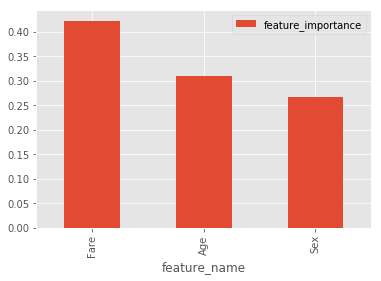

In [150]:
# get feature importances from best estimator
feature_names = model.best_estimator_.named_steps["df_mapper"].transformed_names_
feature_importance = model.best_estimator_.named_steps["model"].feature_importances_

# create a df
df_feature_importance = pd.DataFrame(list(zip(feature_names,feature_importance)),columns=['feature_name','feature_importance'])             
df_feature_importance = df_feature_importance.sort_values(by='feature_importance', ascending=False)

# plot most important features
df_feature_importance.head(20).plot.bar(x='feature_name',y='feature_importance')

## Performance

In [151]:
print(classification_report(y_dev_pred, y_dev))

# make some confusion matrices
rand_cm = ConfusionMatrix(np.array(y_dev.target), np.array(rand_y_dev_pred))
cm = ConfusionMatrix(np.array(y_dev.target), np.array(y_dev_pred))
cm_thold = ConfusionMatrix(np.array(y_dev.target), np.array(y_dev_pred_thold[1].astype(int)))
cm_thold_man = ConfusionMatrix(np.array(y_dev.target), np.array(y_dev_pred_thold_man))

             precision    recall  f1-score   support

          0       0.89      0.74      0.81       121
          1       0.59      0.81      0.68        57

avg / total       0.79      0.76      0.77       178



### Performance: Summary

In [152]:
df_rand_cm_overall = rand_cm.classification_report.transpose()[['__avg / total__']]
df_rand_cm_overall = df_rand_cm_overall.rename(columns={"__avg / total__": "RAND"})

df_cm_overall = cm.classification_report.transpose()[['__avg / total__']]
df_cm_overall = df_cm_overall.rename(columns={"__avg / total__": "MODEL"})

df_cm_thold_overall = cm_thold.classification_report.transpose()[['__avg / total__']]
df_cm_thold_overall = df_cm_thold_overall.rename(columns={"__avg / total__": "THOLD"})

df_cm_thold_man_overall = cm_thold_man.classification_report.transpose()[['__avg / total__']]
df_cm_thold_man_overall = df_cm_thold_man_overall.rename(columns={"__avg / total__": "MANUAL"})

# concat all the df's into one
df_cm_overall_all = pd.concat([df_rand_cm_overall, df_cm_overall, df_cm_thold_overall, df_cm_thold_man_overall],axis=1)
df_cm_overall_all

Classes,RAND,MODEL,THOLD,MANUAL
precision,0.494382,0.76686,0.729691,0.76953
recall,0.494382,0.758427,0.730337,0.764045
F1_score,0.494382,0.751115,0.729921,0.758398
support,178,178,178,178


### Performance: Confusion Matrix

RAND


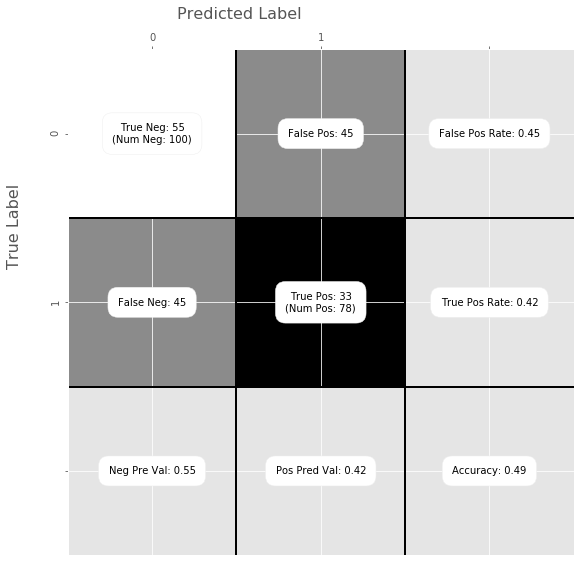

MODEL


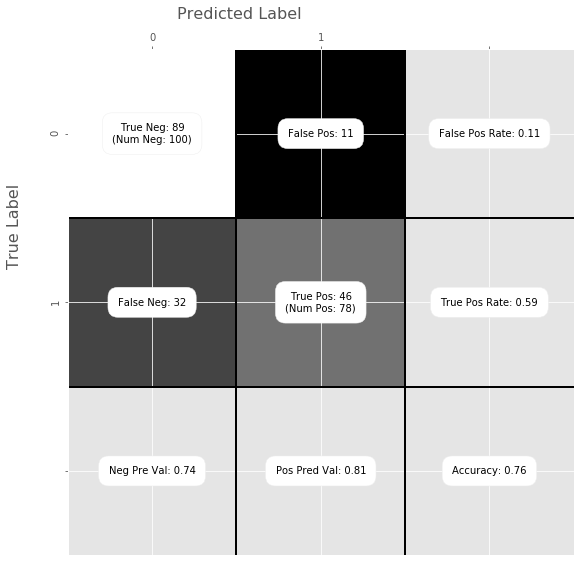

THOLD


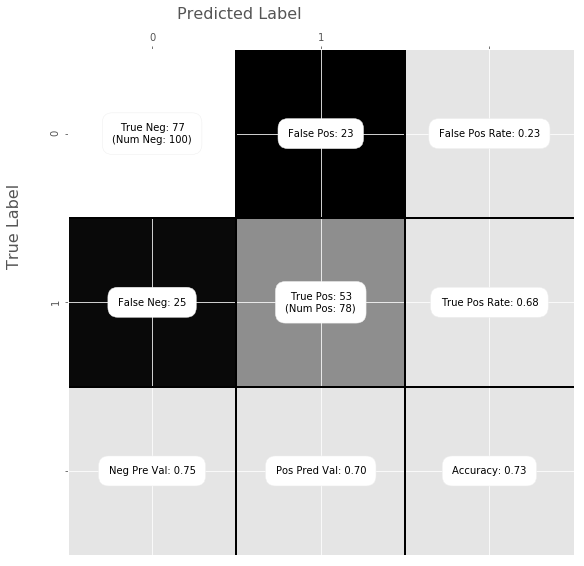

MANUAL


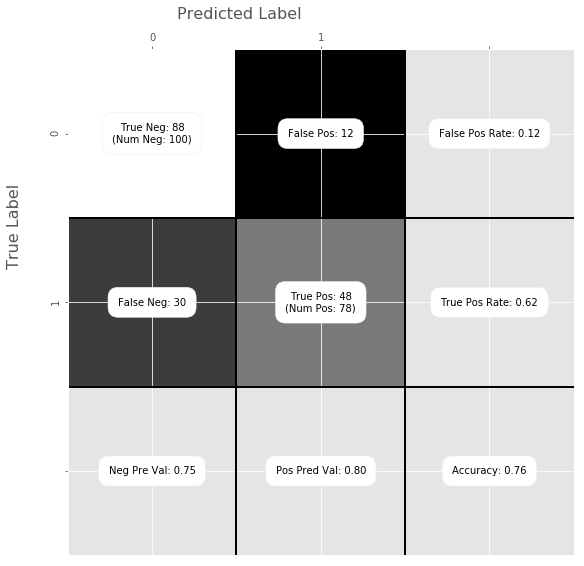

In [153]:
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    Stolen from: http://notmatthancock.github.io/2015/10/28/confusion-matrix.html
    
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()

for label, y_true, y_pred in [('RAND', y_dev, rand_y_dev_pred),
                              ('MODEL', y_dev, y_dev_pred),
                              ('THOLD', y_dev, y_dev_pred_thold[1]), 
                              ('MANUAL', y_dev, y_dev_pred_thold_man)
                             ]:
    print("==================================")
    print(label)
    print("==================================")
    C = confusion_matrix(y_true,y_pred)
    show_confusion_matrix(C, list(model.best_estimator_.classes_))

In [154]:
# convert them to df's with all the usefull info
df_rand_cm = pd.concat([rand_cm.stats_class, pd.DataFrame(rand_cm.stats_overall).transpose()])
df_rand_cm.columns = [str(col) + '_RAND' for col in df_rand_cm.columns]

df_cm = pd.concat([cm.stats_class, pd.DataFrame(cm.stats_overall).transpose()])
df_cm.columns = [str(col) + '_MODEL' for col in df_cm.columns]

df_cm_thold = pd.concat([cm_thold.stats_class, pd.DataFrame(cm_thold.stats_overall).transpose()])
df_cm_thold.columns = [str(col) + '_THOLD' for col in df_cm_thold.columns]

df_cm_thold_man = pd.concat([cm_thold_man.stats_class, pd.DataFrame(cm_thold_man.stats_overall).transpose()])
df_cm_thold_man.columns = [str(col) + '_MANUAL' for col in df_cm_thold_man.columns]

# concat all the df's into one
df_cm_all = pd.concat([df_rand_cm, df_cm, df_cm_thold, df_cm_thold_man],axis=1)
df_cm_all

,0_RAND,1_RAND,0_MODEL,1_MODEL,0_THOLD,1_THOLD,0_MANUAL,1_MANUAL
Population,178,178,178,178,178,178,178,178
P: Condition positive,100,78,100,78,100,78,100,78
N: Condition negative,78,100,78,100,78,100,78,100
Test outcome positive,100,78,121,57,102,76,118,60
Test outcome negative,78,100,57,121,76,102,60,118
TP: True Positive,55,33,89,46,77,53,88,48
TN: True Negative,33,55,46,89,53,77,48,88
FP: False Positive,45,45,32,11,25,23,30,12
FN: False Negative,45,45,11,32,23,25,12,30
"TPR: (Sensitivity, hit rate, recall)",0.55,0.423077,0.89,0.589744,0.77,0.679487,0.88,0.615385


### Performance: ROC

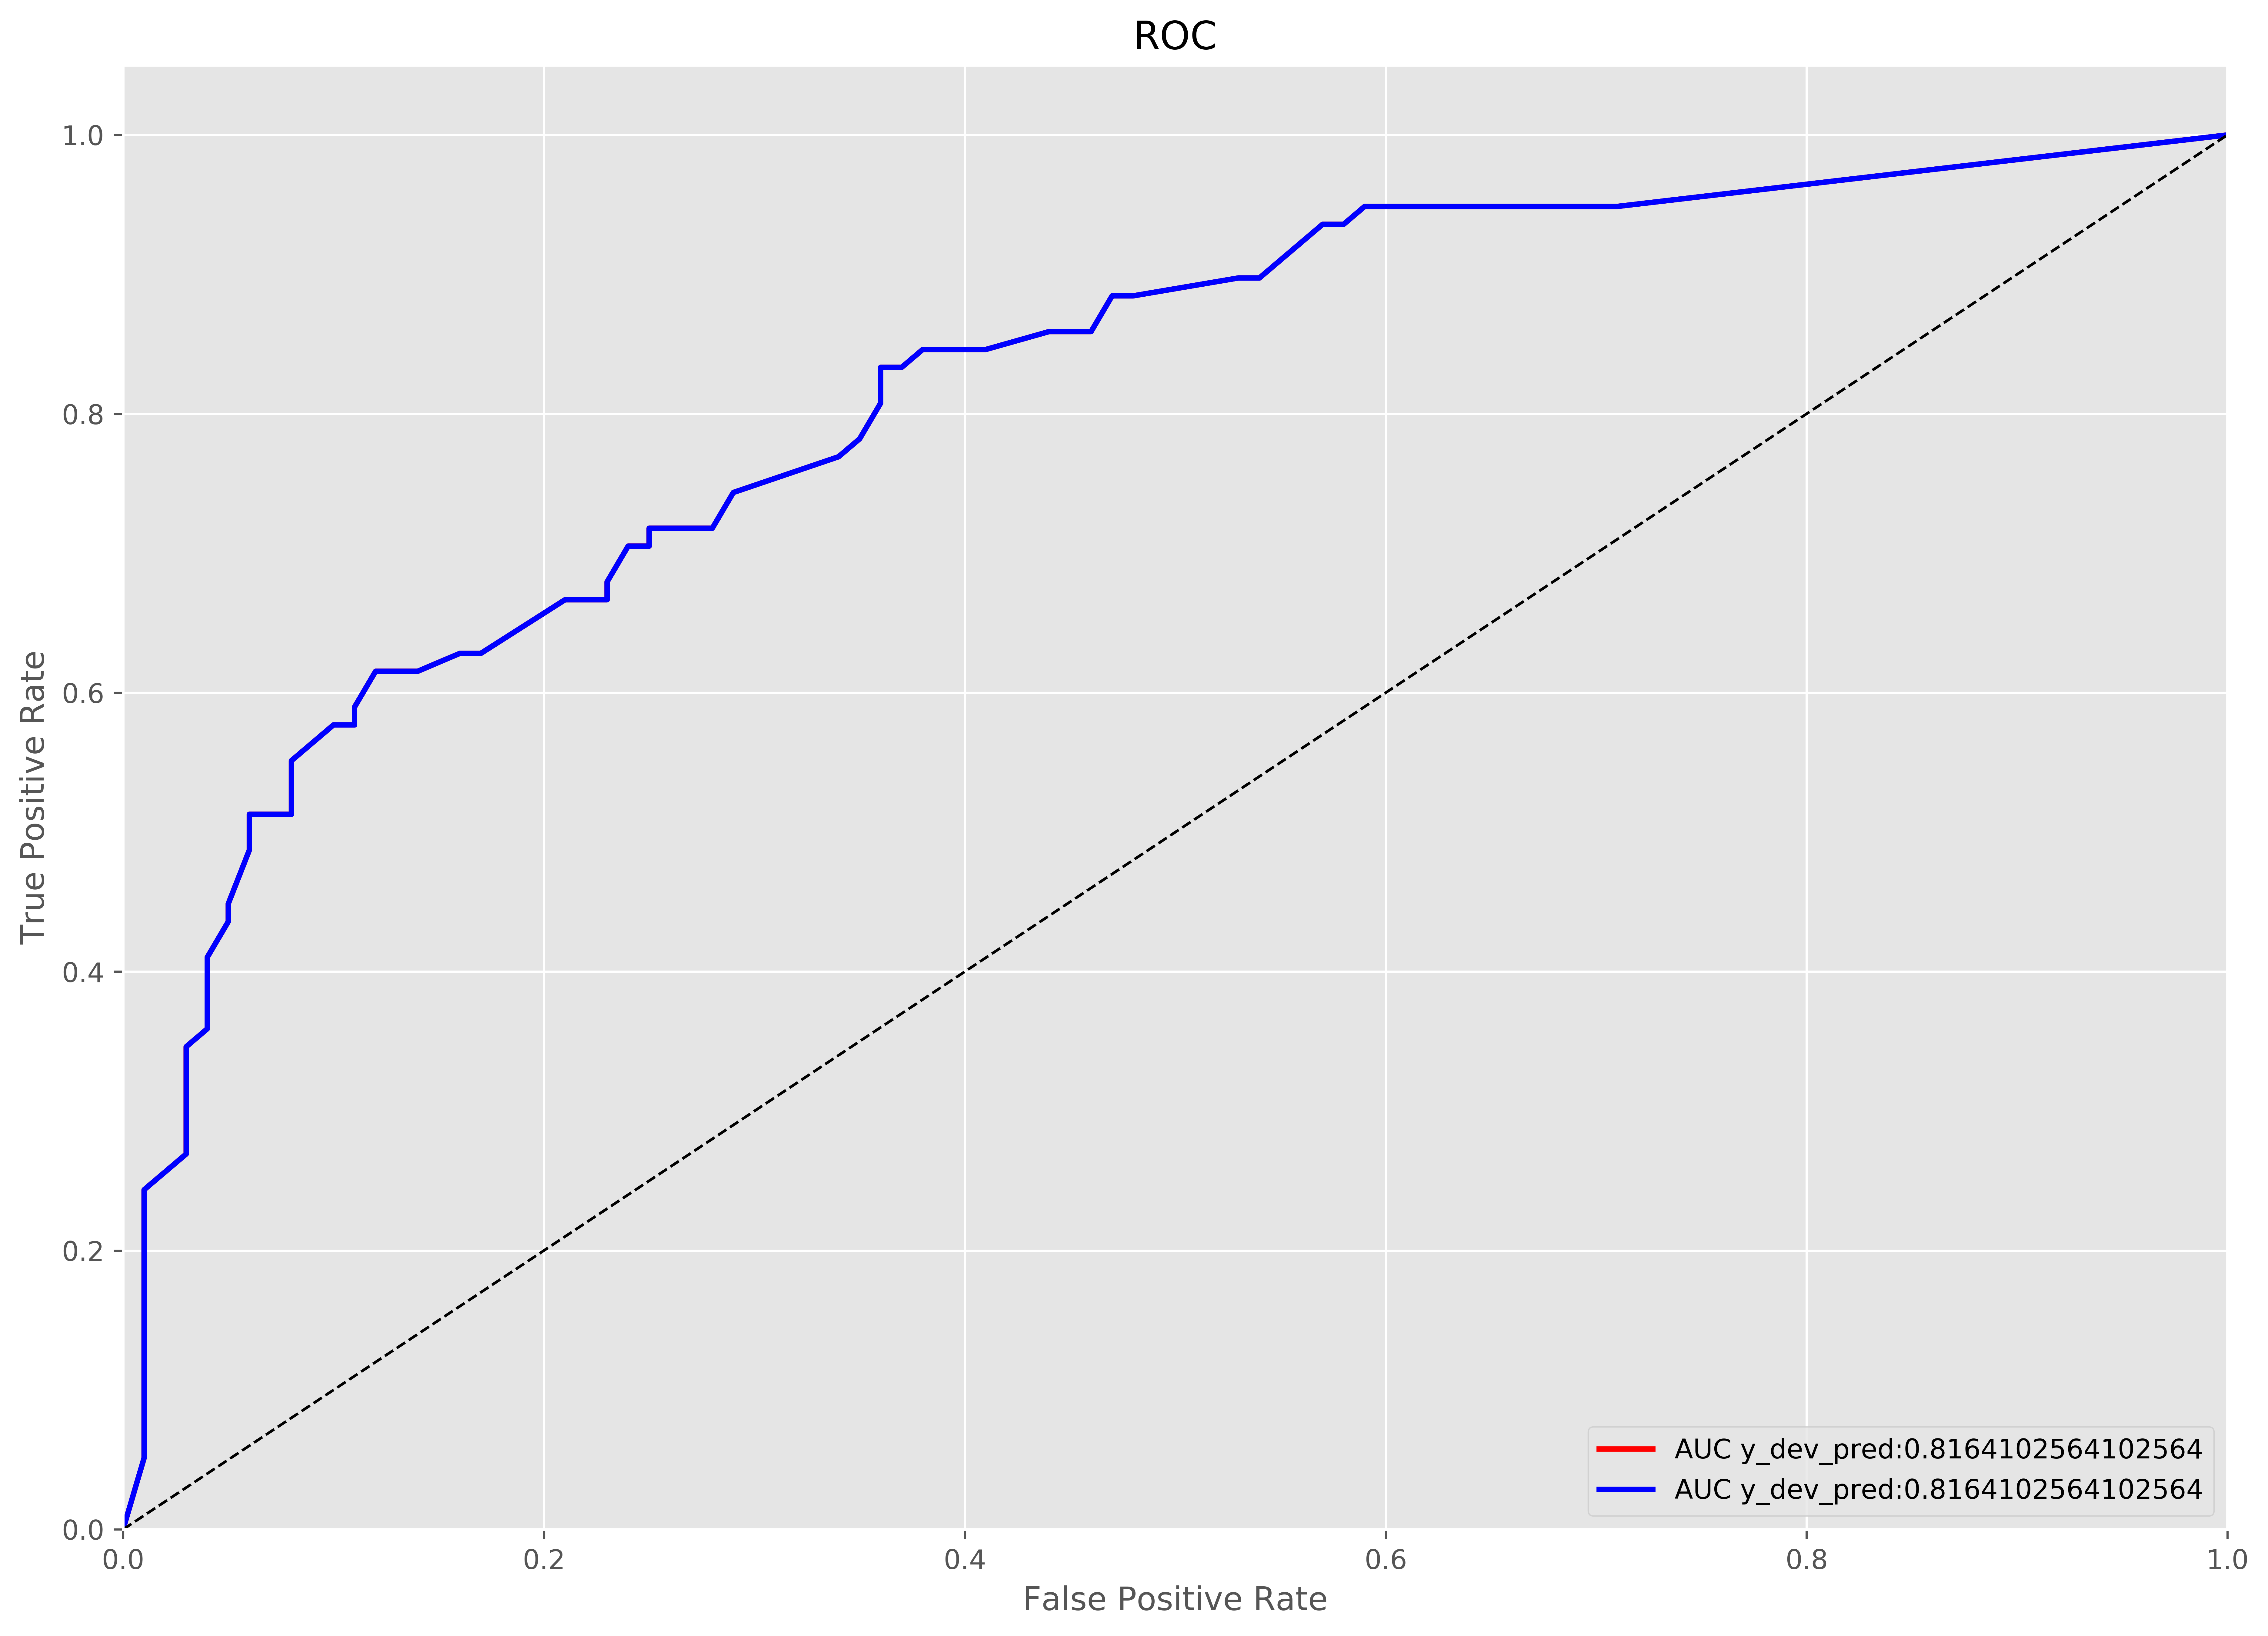

In [155]:
# set up data
y_true = y_dev
y_probs_1 = y_dev_pred_probs[1]
y_probs_1_label = 'y_dev_pred'
y_probs_2 = y_dev_pred_probs[1]
y_probs_2_label = 'y_dev_pred'

# set up plot
plt.figure(figsize=(14,10),dpi=640)
fpr, tpr, thresholds = roc_curve(y_true, y_probs_1)
auc1 = auc(fpr,tpr)

plt.plot(fpr, tpr,label="AUC {0}:{1}".format(y_probs_1_label, auc1),color='red', linewidth=2)

fpr, tpr, thresholds = roc_curve(y_true, y_probs_2)
auc2 = auc(fpr,tpr)

plt.plot(fpr, tpr,label="AUC {0}:{1}".format(y_probs_2_label, auc2),color='blue', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=1) 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate') 
plt.title('ROC') 
plt.grid(True)
plt.legend(loc="lower right")
plt.show()